<a href="https://colab.research.google.com/github/Lister223/Titanic_survived_predict/blob/main/Titanic_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install ydata-profiling

In [ ]:
import pandas as pd
#from ydata_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from pandas.core.frame import DataFrame
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
print(df)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [ ]:
#Describe statistic
Profile = ProfileReport(df, title='Netflix Profile Report', explorative=True)
Profile.to_file("titanic_profile_report.html")

In [ ]:
#"Embarked"empty values(use most class "S" fill)
df["Embarked"] = df["Embarked"].fillna("S")
print(df["Embarked"].isna().any())#check  null

False


1. After test, create Title column can't increase voting model accuracy,but can increase other models'.
2. Use title medium fill age null can't help increase voting model accuracy.

In [ ]:
#fill age
df["Age"] = df["Age"].fillna(df["Age"].median())
print(df["Age"].isna().any())#check  null

False


C:\Users\user\AppData\Local\Temp\ipykernel_2244\3741742114.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival_rate = df.groupby('AgeGroup')['Survived'].mean()


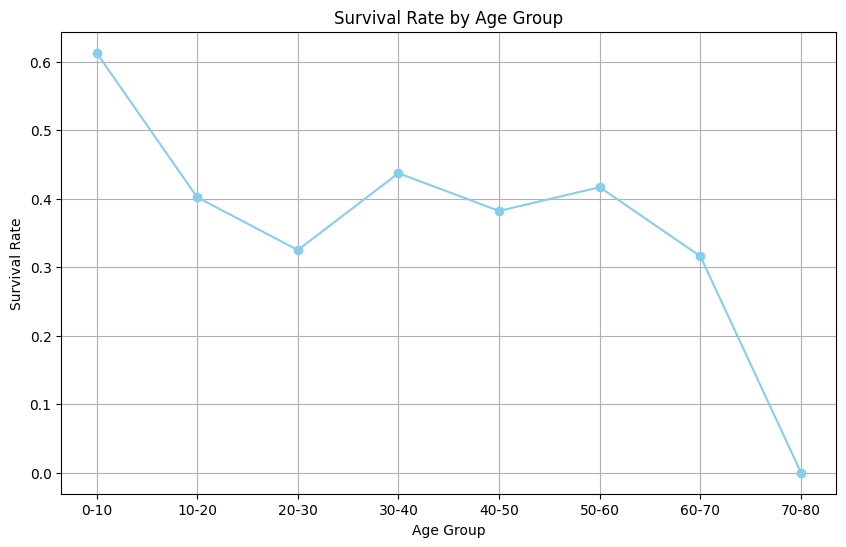

In [ ]:
# Calculate survival rates for different age groups
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)


age_survival_rate = df.groupby('AgeGroup')['Survived'].mean()


plt.figure(figsize=(10, 6))
plt.plot(age_survival_rate.index, age_survival_rate, marker='o', linestyle='-', color='skyblue')
plt.title('Survival Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.grid(True)
plt.show()

#add a new column where age=< 10 "1" else "0"
df['IsChild'] = df['Age'].apply(lambda x : 1 if x <=10 else 0)

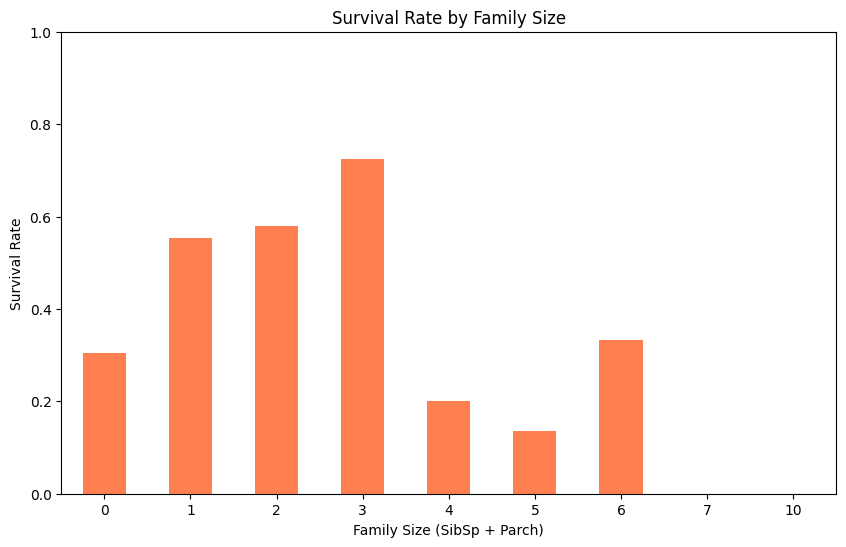

In [ ]:
# create new column family size
df['Family_size'] = df['SibSp'] + df['Parch']

family_survival_rate = df.groupby('Family_size')['Survived'].mean()

plt.figure(figsize=(10, 6))
family_survival_rate.plot(kind='bar', color='coral')
plt.title('Survival Rate by Family Size')
plt.xlabel('Family Size (SibSp + Parch)')
plt.ylabel('Survival Rate')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_2244\3065578733.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_survival_rate = df.groupby('Fare_Category')['Survived'].mean()


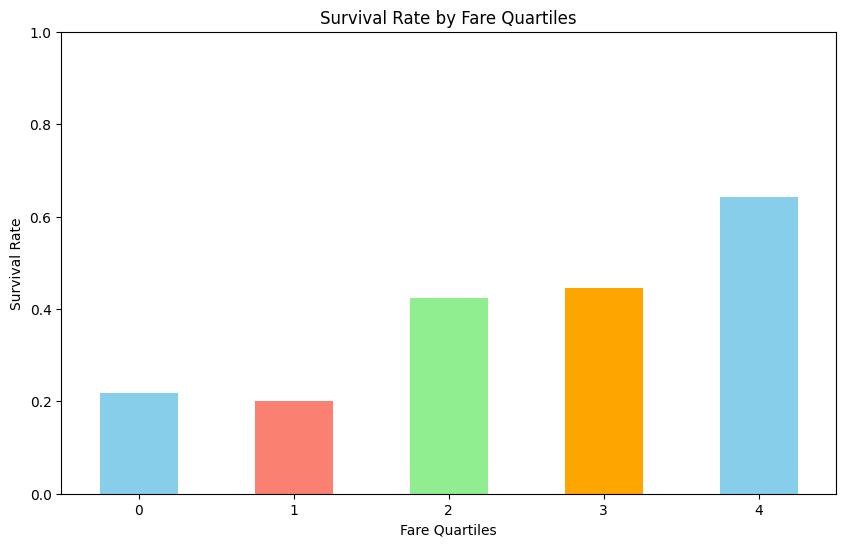

In [ ]:
# Confirm the survival rate of Fare
# 經測試，切5份比4、6份準確率高

df['Fare_Category'] = pd.qcut(df['Fare'], 5, labels=[0, 1, 2, 3, 4])


fare_survival_rate = df.groupby('Fare_Category')['Survived'].mean()


plt.figure(figsize=(10, 6))
fare_survival_rate.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange'])
plt.title('Survival Rate by Fare Quartiles')
plt.xlabel('Fare Quartiles')
plt.ylabel('Survival Rate')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # 確保 y 軸範圍在 0 到 1 之間
plt.show()


In [ ]:
#delete data
columns = ["PassengerId","Name","Ticket","Cabin",'AgeGroup']
df = df.drop(columns=columns)
print(df.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'IsChild', 'Family_size', 'Fare_Category'],
      dtype='object')


In [ ]:
#onehotencoder categorical columns

def multi_onehot_encoder(df:DataFrame, category_columns:list[str]):
    #check columns is exist in dataframe
    for col in category_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    column_transformer = ColumnTransformer(
            transformers=[('categorical', OneHotEncoder(sparse_output=False), category_columns)])
    transformed_array = column_transformer.fit_transform(df)

    #name column_transformer new columns
    col_name = []
    for i, feature in enumerate(category_columns):
        categories = column_transformer.named_transformers_['categorical'].categories_[i]
        for cat in categories:
            col_name.append(f'{feature}_{cat}')
    transformer_df = pd.DataFrame(transformed_array,columns=col_name)
    #concat two dataframe
    df = pd.concat([df,transformer_df],axis=1).drop(columns=category_columns)
    return df


In [ ]:
# use multi_onehot_encoder
category_columns = ["Embarked"]
df = multi_onehot_encoder(df,category_columns)
print(df.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare  IsChild  \
0         0       3    male  22.0      1      0   7.2500        0   
1         1       1  female  38.0      1      0  71.2833        0   
2         1       3  female  26.0      0      0   7.9250        0   
3         1       1  female  35.0      1      0  53.1000        0   
4         0       3    male  35.0      0      0   8.0500        0   

   Family_size Fare_Category  Embarked_C  Embarked_Q  Embarked_S  
0            1             0         0.0         0.0         1.0  
1            1             4         1.0         0.0         0.0  
2            0             1         0.0         0.0         1.0  
3            1             4         0.0         0.0         1.0  
4            0             1         0.0         0.0         1.0  


In [ ]:
def multi_label_encoder(df: pd.DataFrame, category_columns: list[str]) -> pd.DataFrame:
    for col in category_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    for col in category_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    return df

In [ ]:
# use multi_label_encoder
category_columns = ["Sex"]
df = multi_label_encoder(df,category_columns)
print(df.head())

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  IsChild  Family_size  \
0         0       3    1  22.0      1      0   7.2500        0            1   
1         1       1    0  38.0      1      0  71.2833        0            1   
2         1       3    0  26.0      0      0   7.9250        0            0   
3         1       1    0  35.0      1      0  53.1000        0            1   
4         0       3    1  35.0      0      0   8.0500        0            0   

  Fare_Category  Embarked_C  Embarked_Q  Embarked_S  
0             0         0.0         0.0         1.0  
1             4         1.0         0.0         0.0  
2             1         0.0         0.0         1.0  
3             4         0.0         0.0         1.0  
4             1         0.0         0.0         1.0  


In [ ]:
# standard scaler
def standard_scaler(df:DataFrame, numeric_columns:list[str]):
    #check columns is exist in dataframe
    for col in numeric_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

In [ ]:
# use standard scaler to numeric variable 'age'&'fare'
numeric_columns = ["Age","Fare"]
df = standard_scaler(df,numeric_columns)
print(df.head())

   Survived  Pclass  Sex       Age  SibSp  Parch      Fare  IsChild  \
0         0       3    1 -0.565736      1      0 -0.502445        0   
1         1       1    0  0.663861      1      0  0.786845        0   
2         1       3    0 -0.258337      0      0 -0.488854        0   
3         1       1    0  0.433312      1      0  0.420730        0   
4         0       3    1  0.433312      0      0 -0.486337        0   

   Family_size Fare_Category  Embarked_C  Embarked_Q  Embarked_S  
0            1             0         0.0         0.0         1.0  
1            1             4         1.0         0.0         0.0  
2            0             1         0.0         0.0         1.0  
3            1             4         0.0         0.0         1.0  
4            0             1         0.0         0.0         1.0  


In [ ]:
# set X y
X = df.drop(columns=["Survived"])
y = df["Survived"]

In [ ]:
# set val_dataset
new_df = pd.read_csv(r'.\test.csv')
print(new_df.isna().any())

#"Embarked"empty values(use most class "S" fill)
new_df["Embarked"] = new_df["Embarked"].fillna("S")
print(new_df["Embarked"].isna().any())#check  null

# fill age, use median
new_df["Age"] = new_df["Age"].fillna(new_df["Age"].median())
print(new_df["Age"].isna().any())#check  null

# add a new column where age=< 10 "1" else "0"
new_df['IsChild'] = new_df['Age'].apply(lambda x : 1 if x <=10 else 0)

#fill fare, use median
new_df["Fare"] = new_df["Fare"].fillna(new_df["Fare"].median())
print(new_df["Fare"].isna().any())#check  null

# create family size
new_df['Family_size'] = new_df['SibSp'] + new_df['Parch']

# create  fare classigory
new_df['Fare_Category'] = pd.qcut(new_df['Fare'], 4, labels=[0, 1, 2, 3])

# use multi_onehot_encoder
category_columns = ["Embarked"]
new_df = multi_onehot_encoder(new_df,category_columns)

# use standard scaler to numeric variable 'age'&'fare'
numeric_columns = ["Age","Fare"]
new_df = standard_scaler(new_df,numeric_columns)

# use multi_label_encoder
category_columns = ["Sex"]
new_df = multi_label_encoder(new_df,category_columns)

# set X_val
X_new = new_df.drop(columns=["PassengerId","Name","Ticket","Cabin"])
print(X_new.count())
print(X_new.head())

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool
False
False
False
Pclass           418
Sex              418
Age              418
SibSp            418
Parch            418
Fare             418
IsChild          418
Family_size      418
Fare_Category    418
Embarked_C       418
Embarked_Q       418
Embarked_S       418
dtype: int64
   Pclass  Sex       Age  SibSp  Parch      Fare  IsChild  Family_size  \
0       3    1  0.386231      0      0 -0.497413        0            0   
1       3    0  1.371370      1      0 -0.512278        0            1   
2       2    1  2.553537      0      0 -0.464100        0            0   
3       3    1 -0.204852      0      0 -0.482475        0            0   
4       3    0 -0.598908      1      1 -0.417492        0            2   

  Fare_Category  Embarked_C  

LogisticRegression Best parameters found: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}

C:\Users\TMP214\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
375 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\TMP214\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\TMP214\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\TMP214\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1194, in fit
    solv

Best parameters found: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
Best cross-validated accuracy: 0.80


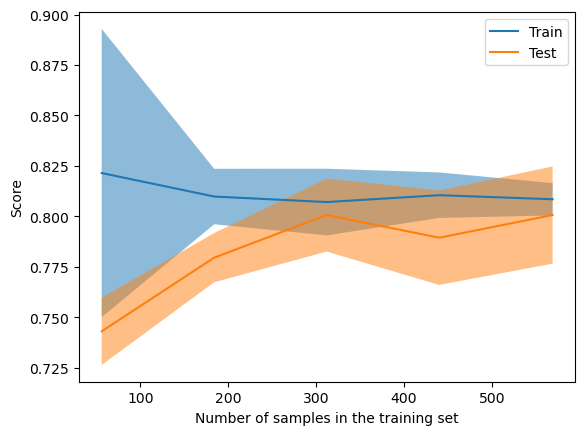

------------------------------


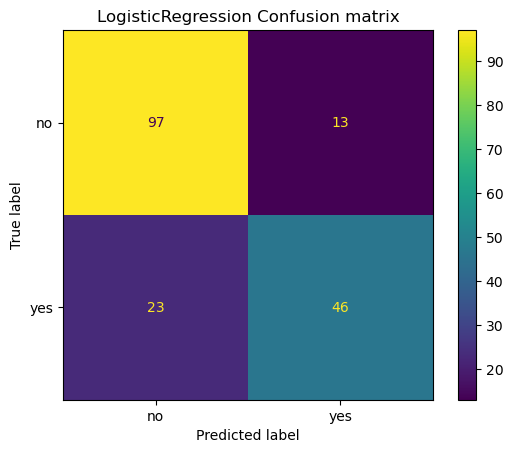

TEST 2 metrix report :
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       110
           1       0.78      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179



In [ ]:
# TEST 2: use stratified kfold & gred search to train model

# split train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
# kfold set
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# model set
model = LogisticRegression(max_iter=1000)

# grid set
grid_params = {'C': [0.001, 0.01, 0.1, 1, 10],
            'solver': ['lbfgs', 'liblinear', 'newton-cg'],
            'penalty': ['l1','12'],
            'tol': [1e-3,1e-4,1e-5]
              }

# grid search
grid_search = GridSearchCV(estimator=model,
              param_grid=grid_params,
              cv=stratified_kfold,
              scoring='accuracy')

# train
grid_search.fit(X_train, y_train)

# print best params
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f'Best parameters found: {best_params}')
print(f'Best cross-validated accuracy: {best_score:.2f}')



# best train
# use learn curve
best_model = grid_search.best_estimator_
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train)
display = LearningCurveDisplay(train_sizes=train_sizes,
    train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()
print("---"*10)

# predict
y_pred = best_model.predict(X_test)

# confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                        display_labels= ['no', 'yes']
                        )
disp.ax_.set_title('LogisticRegression Confusion matrix');
plt.show()

# metrix report
print(f'TEST 2 metrix report :\n {classification_report(y_test, y_pred)}')

In [ ]:
# TEST 2 use logistic_best_model prdict X_val
y_pred = best_model.predict(X_new)

result = pd.DataFrame()
result['PassengerId'] = new_df['PassengerId']
result['Survived'] = y_pred
print(result.head())

result.to_csv('logistic_result.csv', index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0


GradientBoostingClassifier pharms: min_samples_split = 10, n_estimators = 200, tol = 1e-05 , other is default

GBC_Best parameters found: {'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.6, 'tol': 1e-05}
GBC_Best cross-validated accuracy: 0.83


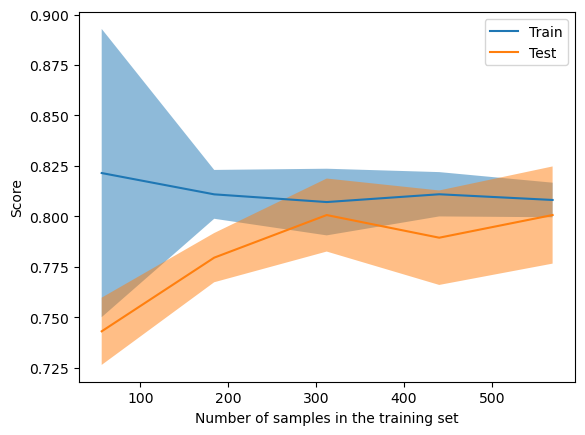

------------------------------


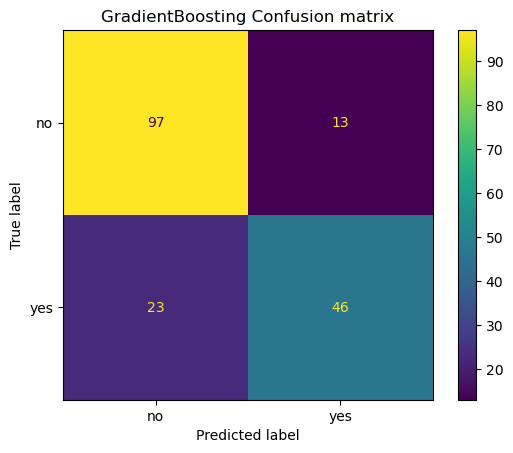

TEST 3 metrix report :
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       110
           1       0.78      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179



In [ ]:
# TEST 3: use stratified kfold & gred search $Gradient Boosting to train model

# split train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# kfold set
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# model set
GBC_model = GradientBoostingClassifier(warm_start=True)

# param grid set
param_grid = {
    'n_estimators': [200, 300],
    'tol': [1e-5, 1e-4, 1e-3],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10],
}

# GridSearchCV
grid_search_GBC = GridSearchCV(estimator=GBC_model, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy')

# train
grid_search_GBC.fit(X_train, y_train)

# print best params
GBC_best_params = grid_search_GBC.best_params_
GBC_best_score = grid_search_GBC.best_score_
print(f'GBC_Best parameters found: {GBC_best_params}')
print(f'GBC_Best cross-validated accuracy: {GBC_best_score:.2f}')



# best train
# use learn curve
GBC_best_model = grid_search.best_estimator_
train_sizes, train_scores, test_scores = learning_curve(GBC_best_model, X_train, y_train)
display = LearningCurveDisplay(train_sizes=train_sizes,
    train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()
print("---"*10)

# use test predict
y_pred = GBC_best_model.predict(X_test)

# confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['no', 'yes'])
disp.ax_.set_title('GradientBoosting Confusion matrix');
plt.show()

# metrix report
print(f'TEST 3 metrix report :\n {classification_report(y_test, y_pred)}')


In [ ]:
# Test3 use GBC_best_model prdict X_val
y_pred = GBC_best_model.predict(X_new)

result = pd.DataFrame()
result['PassengerId'] = new_df['PassengerId']
result['Survived'] = y_pred
print(result.head())

result.to_csv(' GBC_result.csv', index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0


voting_Best parameters found: {'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'rf__n_estimators': 100, 'svc__C': 1, 'svc__class_weight': None}
voting_Best cross-validated accuracy: 0.84


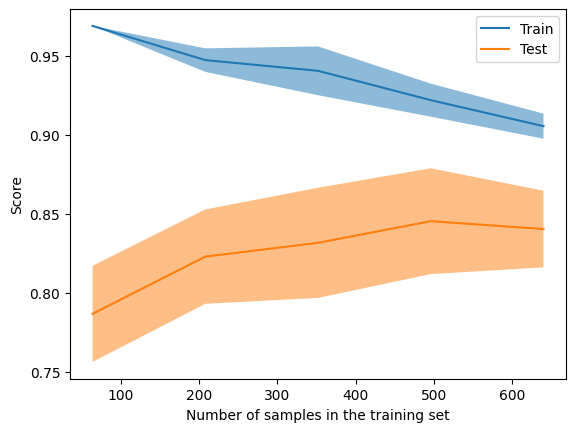

------------------------------


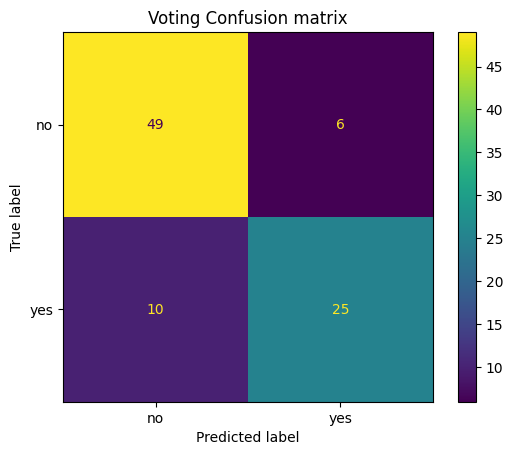

TEST 4 metrix report :
               precision    recall  f1-score   support

           0       0.83      0.89      0.86        55
           1       0.81      0.71      0.76        35

    accuracy                           0.82        90
   macro avg       0.82      0.80      0.81        90
weighted avg       0.82      0.82      0.82        90



In [ ]:
# TEST 4: use voting classifer

# split train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)

# kfold set
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# base model set
logistic = LogisticRegression(max_iter = 1000,C = 10,penalty = 'l1', solver = 'liblinear')
rf = RandomForestClassifier(warm_start = True)
gbc = GradientBoostingClassifier(min_samples_split = 10, n_estimators = 200, tol = 1e-05)
svc = SVC(probability=True)
knn = KNeighborsClassifier(weights='uniform')

# param grid set
param_grid = {'rf__n_estimators': [50, 100, 200],
              'svc__C': [0.1, 1, 10],
              'svc__class_weight': [None,'balanced'],
              'knn__n_neighbors': [3, 5, 7],
              'knn__weights': ['uniform', 'distance'] }

# set VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('lr', logistic),
                ('rf', rf),
                ('gbc', gbc),
                ('svc', svc),
                ('knn', knn)], voting='soft')

# GridSearchCV
grid_search_voting = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy',n_jobs=-1)

# train
grid_search_voting.fit(X_train, y_train)

# print best params
voting_best_params = grid_search_voting.best_params_
voting_best_score = grid_search_voting.best_score_
print(f'voting_Best parameters found: {voting_best_params}')
print(f'voting_Best cross-validated accuracy: {voting_best_score:.2f}')

# best train
# use learn curve
voting_best_model = grid_search_voting.best_estimator_
train_sizes, train_scores, test_scores = learning_curve(voting_best_model, X_train, y_train)
display = LearningCurveDisplay(train_sizes=train_sizes,
    train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()
print("---"*10)

# use test predict
y_pred = voting_best_model.predict(X_test)

# confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['no', 'yes'])
disp.ax_.set_title('Voting Confusion matrix');
plt.show()

# metrix report
print(f'TEST 4 metrix report :\n {classification_report(y_test, y_pred)}')


In [ ]:
# use voting_best_model prdict X_val
y_pred = voting_best_model.predict(X_new)

result = pd.DataFrame()
result['PassengerId'] = new_df['PassengerId']
result['Survived'] = y_pred
print(result.head())

result.to_csv('voting_model_result11.csv', index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


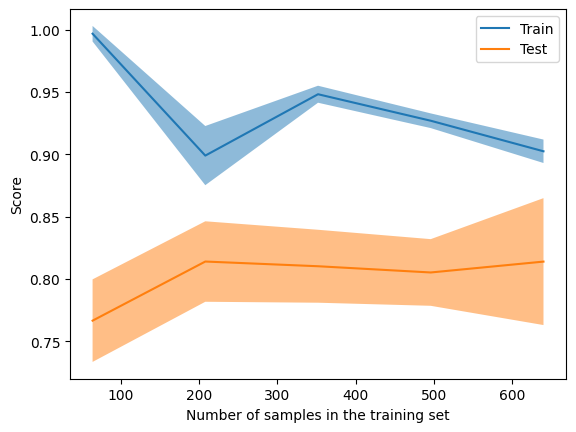

------------------------------
Accuracy: 0.80


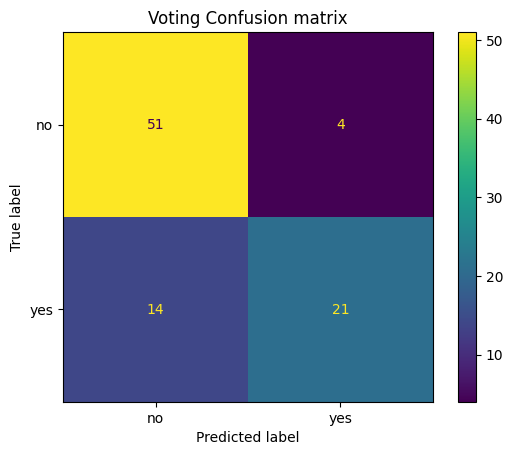

TEST 4 metrix report :
               precision    recall  f1-score   support

           0       0.78      0.93      0.85        55
           1       0.84      0.60      0.70        35

    accuracy                           0.80        90
   macro avg       0.81      0.76      0.77        90
weighted avg       0.81      0.80      0.79        90



In [ ]:
# split train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)

# kfold set
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 建立分類器
mlp_model = MLPClassifier(hidden_layer_sizes=(64,32,16), max_iter=500, random_state=42)

# 訓練模型
mlp_model.fit(X_train, y_train)

# 預測並評估模型
train_sizes, train_scores, test_scores = learning_curve(mlp_model, X_train, y_train)
display = LearningCurveDisplay(train_sizes=train_sizes,
    train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()
print("---"*10)

# use test predict
y_pred = mlp_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['no', 'yes'])
disp.ax_.set_title('Voting Confusion matrix');
plt.show()

# metrix report
print(f'TEST 4 metrix report :\n {classification_report(y_test, y_pred)}')


voting_Best parameters found: {'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'rf__n_estimators': 50, 'svc__C': 1, 'svc__class_weight': None}
voting_Best cross-validated accuracy: 0.84


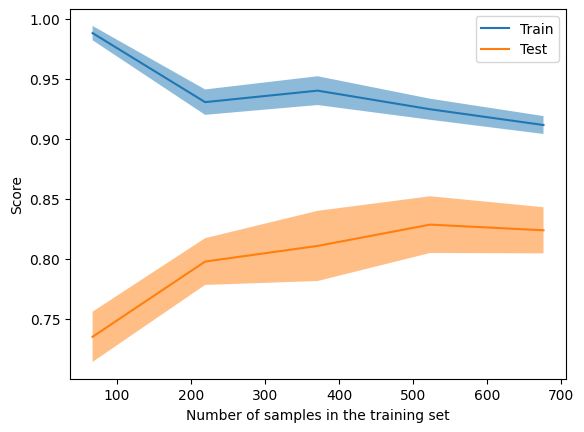

------------------------------


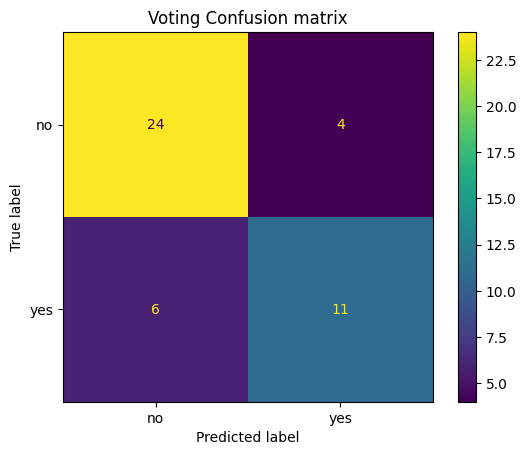

TEST 5 metrix report :
               precision    recall  f1-score   support

           0       0.80      0.86      0.83        28
           1       0.73      0.65      0.69        17

    accuracy                           0.78        45
   macro avg       0.77      0.75      0.76        45
weighted avg       0.77      0.78      0.77        45



In [ ]:
# TEST 5: use voting classifer

# split train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=True, stratify=y)

# kfold set
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# base model set
logistic = LogisticRegression(max_iter = 1000,C = 10,penalty = 'l1', solver = 'liblinear')
rf = RandomForestClassifier(warm_start = True)
gbc = GradientBoostingClassifier(min_samples_split = 10, n_estimators = 200, tol = 1e-05)
svc = SVC(probability=True)
knn = KNeighborsClassifier(weights='uniform')
mlp = MLPClassifier(hidden_layer_sizes=(64,16), solver ='adam',random_state=42,max_iter=2000)

# param grid set
param_grid = {'rf__n_estimators': [50, 100, 200],
              'svc__C': [0.1, 1, 10],
              'svc__class_weight': [None,'balanced'],
              'knn__n_neighbors': [3, 5, 7],
              'knn__weights': ['uniform', 'distance'] }

# set VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('lr', logistic),
                ('rf', rf),
                ('gbc', gbc),
                ('svc', svc),
                ('knn', knn),
                ('mlp',mlp)], voting='soft')

# GridSearchCV
grid_search_voting = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy',n_jobs=-1)

# train
grid_search_voting.fit(X_train, y_train)

# print best params
voting_best_params = grid_search_voting.best_params_
voting_best_score = grid_search_voting.best_score_
print(f'voting_Best parameters found: {voting_best_params}')
print(f'voting_Best cross-validated accuracy: {voting_best_score:.2f}')

# best train
# use learn curve
voting_best_model = grid_search_voting.best_estimator_
train_sizes, train_scores, test_scores = learning_curve(voting_best_model, X_train, y_train)
display = LearningCurveDisplay(train_sizes=train_sizes,
    train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()
print("---"*10)

# use test predict
y_pred = voting_best_model.predict(X_test)

# confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['no', 'yes'])
disp.ax_.set_title('Voting Confusion matrix');
plt.show()

# metrix report
print(f'TEST 5 metrix report :\n {classification_report(y_test, y_pred)}')

In [ ]:
# use voting_best_model prdict X_val
y_pred = voting_best_model.predict(X_new)

result = pd.DataFrame()
result['PassengerId'] = new_df['PassengerId']
result['Survived'] = y_pred
print(result.head())

result.to_csv('voting_model_result11.csv', index=False) #0.79186 accuracy

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
